**Chapter 2 – End-to-end Machine Learning project**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

*This notebook contains my version of this notebook.*

Main Steps
1. Look at the big picture.
2. Get the data.
3. Discover and visualize the data to gain insights.
4. Prepare the data for Machine Learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system

# 1 Look at the big picture

**Task:** <br>
using California census data, build a model should learn from this data and be able to predict the median housing price in any district, given all the other metrics

*Dataset Overview* <br>
The data includes metrics such as the population, median income, and median
housing price for each block group or district in California



## Frame the Problem



**Question 1: What is the business objective?** <br> 
(How does the company expect to use and benefit from this model?)

*Why is this important* <br>
Knowing the objective is important because
*   it will determine how to frame the problem
*   which algorithms you will select
*   which performance measure you will use to evaluate your model
*   how much effort you will spend tweaking it

**Answer**:  model’s output (a prediction of a district’s median housing price) will be fed to another Machine Learning system along with many other signals.

*see figure2-2 for flowchart of the pipeline*


**Question 2: What does the current solution look like?**

*Why is this important*
*   give you a reference for performance
*   insights on how to solve the problem

**Answer:** district housing prices are currently estimated manually by experts: a team gathers up-to-date information about a district, and when they cannot get the median housing price, they estimate it using complex rules

**Cons of their solution:**
* costly and time-consuming
* their estimates are not great--in cases
where they manage to find out the actual median housing price, they often
realize that their estimates were off by more than 20%

**Why is our solution useful to them**
* it would be useful to train a model to predict a district’s
median housing price, given other data about that district
* census data looks like a great dataset to exploit for this purpose, since it includes the median housing prices of thousands of districts, as well as other data





**Specifying the Problem (Technically)**

Supervised Learning system <br>
-given the nature of our dataset (we have features and the ground truth labels)

Regression problem <br>
-since we're targeting continuous values for the target
* multiple regression - given our numerous features
* univariate regression - since we only need one output

Plain Batch Learning <br>
-since data won't continuously flow into the system <br>
-the data is small so it doesn't need to be chunked or dealt with more machines


## Select a Performance Measure

Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) are the candidates.

# 2 Get the Data

In [ ]:
# imports and othe needed prereqs

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Download the Data

In [ ]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [ ]:
fetch_housing_data()

## Take a Quick Look at the Data Structure

In [ ]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [ ]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Given the ``` housing.info() ```, we can say that:
1. All have same Non-null values of 20, 640 instances except total_bedrooms. So there are missing values here that later we need to take into account. 
2. All except the ocean_proximity are floats
3. Ocean_proximity is recognized as object but this is because it's in string format. Given also ``` housing.head() ``` , we can say that the values here are repetitive. Most likely, it's a categorical feature.




In [ ]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure attribute_histogram_plots


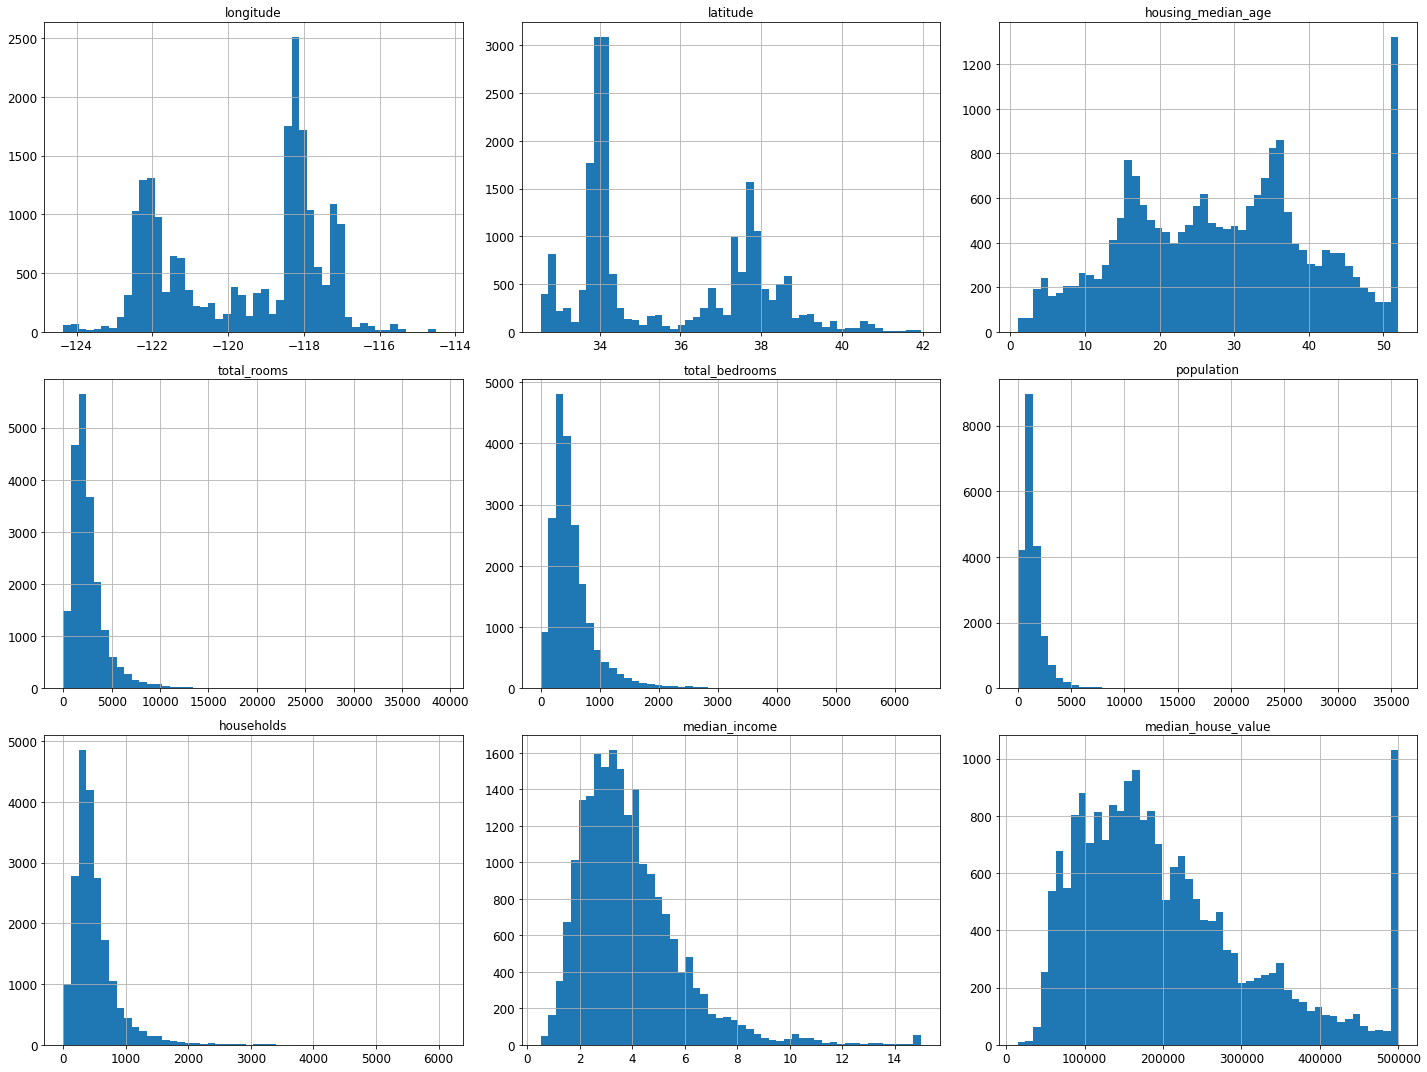

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

What do these histograms say?

1. the median income attribute does not look like it is expressed in US dollars (USD). <br>
Checking with team responsible for the data, it confirmed this hypothesis and told further that the data is: <br>
a. capped: at 15 (actually, 15.0001) for higher median incomes, and at 0.5 (actually, 0.4999) for lower median incomes<br> 
b. scaled: The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000).

2. The housing median age and the median house value were also capped. <br>
This can be a problem to the median house value since this is the target variable--the algo may learn that prices never go beyond that limit.

**Depends on the client team if this is a problem or not** <br>
a. Not a Problem: if they need predictions capped at that value <br>
b. Problem: if they need precise predictions even beyond $500,000

If they chose that it is a problem, there are two ways: <br>
1.) Collect proper labels for the districts whose labels were
capped <br>
2.) Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond $500,000)

3. These attributes have very different scales. Thus, feature scaling is needed.

4. Many histograms are tail-heavy. May make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

## Create a Test Set

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


Suppose you chatted with experts who told you that the median income is a
very important attribute to predict median housing prices. 

**You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset.**




Thus, we need to do stratified sampling than the random sampling. 

So to have a basis for stratification, we need categories to form each stratum. We can do this by introducing an attribute--```housing["income_cat"]``` that does the categorization of ```median_income```. 

Pandas have a way of doing this via [```pd.cut```](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html)
Use cut when you need to segment and sort data values into bins. 
This function is also useful for going from a continuous variable to a categorical variable. 

Note: <br>
It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of a stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. 

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [ ]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

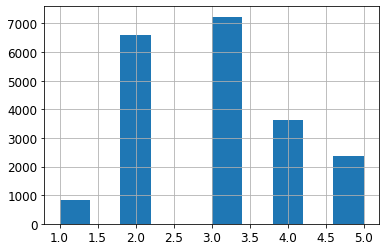

In [ ]:
housing["income_cat"].hist()

Now that we have the basis for stratification, ```housing['income_cat']```, we are ready to do stratified sampling based on the income category.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# split 'housing' via housing['income_cat'] 
# housing['income-cat'] is the y or target variable in the
# sense that stratification is done based on this
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [ ]:
# see percentage of the distribution per set
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

We now compare the proportions. We expect that the stratified test set distribution have lesser difference to the whole dataset distribution. 

In [ ]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [ ]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


As we can see, the test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using purely random sampling is skewed. 

We drop the added attribute which is the basis of stratification on both stratified train and test set since we won't be needing it anymore. 

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

**Important:**
* Do not confuse **stratification** with **feature scaling** in what we just did. Recall the definition. 

**Stratification** <br>
-the population is divided into homogeneous subgroups called strata
-the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population

**Feature Scaling** <br>
-done for the features to have uniform scales.

**Overall Remark:** <br>
We spent quite a bit of time on test set generation for a good reason: this is  an often neglected but critical part of a Machine Learning project. \

Moreover, many of these ideas will be useful later when we discuss cross-validation.

# 3 Discover and Visualize the Data to Gain Insights

**Caution!** Only explore the training set

Since our training set is small, we can use it fully. 


In [ ]:
# copy the training set so we won't harm it
housing = strat_train_set.copy()

## Visualizing Geographical Data

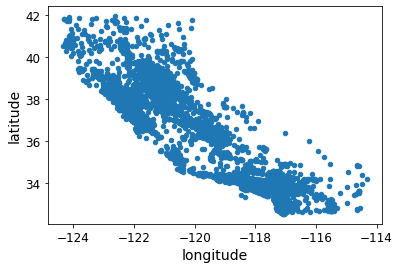

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude")

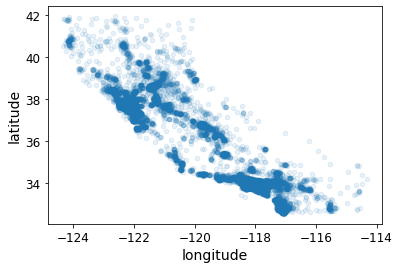

In [ ]:
# better viz for seeing density
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

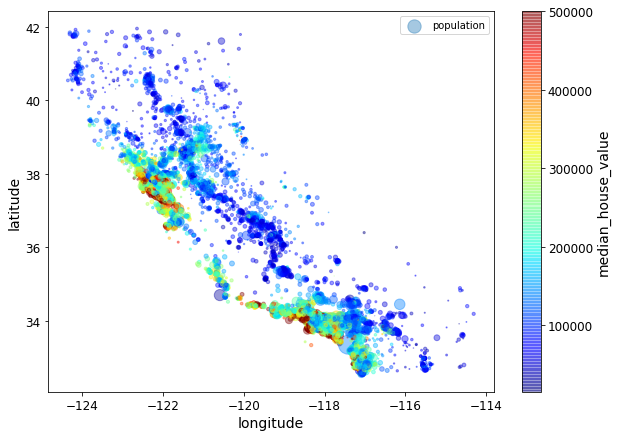

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

In [ ]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7f4aec928be0>)

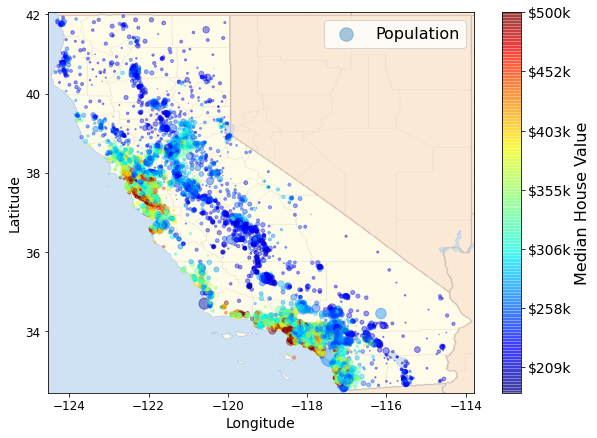

In [ ]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

Here we explored the population and median house values geographically.

We can derive some insights about our data using this plot: <br>

* The median house value has a relationship with the ocean proximity attribute <br> 
     - Most coastal parts have higher median house value except the northern parts.
* Population density also has a relationship with ocean proximity attribute <br>
     - in areas with higher median house value, most have smaller population. 
     

## Looking at Correlations

### (2) Two ways to look for correlation

In [ ]:
# 1. Using Pearson's r
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ae8fcacf8>,
      dtype=object)

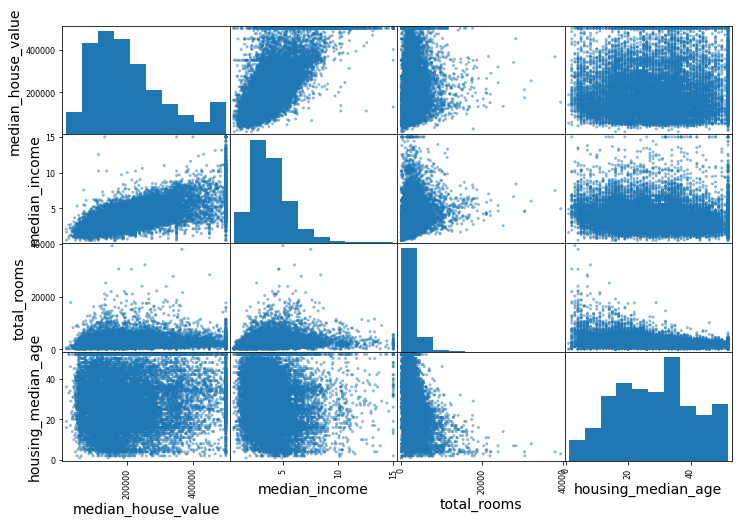

In [ ]:
# 2. Using pandas' scatter_matrix function

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

### Zooming into the Most Promising Attribute

(0.0, 16.0, 0.0, 550000.0)

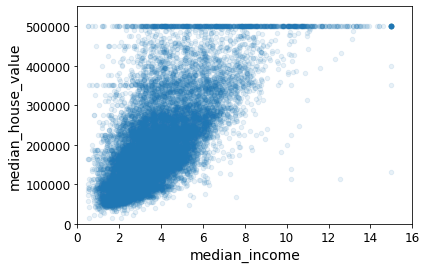

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

Observations:
* There is a strong positive correlation with median_income and median_house_value
* The 500k cap can be seen as the horizontal line
* There are also horinzontal lines present in some y values. We may remove this later to prevent the algorithm learning these quirks. 

## Experimenting with Attribute Combinations

1. Add additional attribute by combining original attributes
   - Usually this is done by getting the proportion of two related attributes.
   - Other types of combinations lie on the intersting relationships between attributes. 

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

2. Next, we can look again the at the correlations together with these additional attributes.

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

The resulting new attributes sometimes have better correlations with the target attribute than their original counterparts like total_bedrooms vs. bedrooms per room and total rooms, households vs rooms per household. 

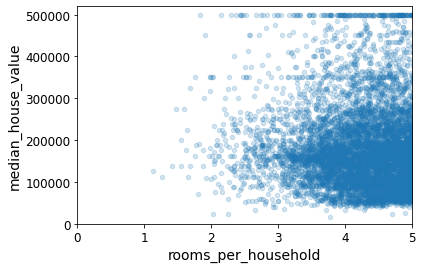

In [ ]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


## Overall Remark

So far we've gained insights to help us with our future approaches.
1. We knew about some data quirks that we want to clean later on
2. Interesting correlation between attributes, especially with the target attribute
3. Some attributes have heavy tail distribution, so we may want to do transformations.
4. Trying out different attribute combinations let us introduce new interesting features (this tho is added later after cleaning the data since it does not makes any sense to get attrib combinations of data points that needs to be cleaned)

Further notes:
* Of course, your mileage will vary considerably
with each project, but the general ideas are similar.

* This round of exploration does not have to be absolutely thorough; the point is to start off on the right foot and quickly **gain insights that will help you get a first reasonably good prototype**. 

* **But this is an iterative process**: once you get a prototype up and running, you can analyze its output to gain more insights and come back to this exploration step.

# 4 Prepare the Data for Machine Learning Algorithms

## Data Cleaning [and Handling Numerical Attributes]

This part focuses on handling missing numerical data.
Recall from before that the total number of bedrooms have missing data, so we will be focusing there.

In [ ]:
# Make sure that you only do this in the training data
housing =  strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### There are 3 options

We will show here the from scratch implementation of these

In [ ]:
# we copy the orig data
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()

In [ ]:
# Option 1: Removing the corresponding districts with nulls
sample_incomplete_rows.dropna(subset=["total_bedrooms"])

In [ ]:
# Option 2: Removing the whole attribute
sample_incomplete_rows.drop("total_bedrooms", axis=1)

In [ ]:
# Option 3: Replacing nulls with some values (e.g. zero, mean, median, etc)
# here we do the median

median = sample_incomplete_rows["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)

### Scikit-Learn's way of Handling Missing Data via ```SimpleImputer```

1. Create a SimpleImputer instance

In [ ]:
from sklearn.impute import SimpleImputer

# create an instance
imputer = SimpleImputer(strategy="median") # replace missing values with median

2. Remove non-numerical attributes or text attributes because median can only be calculated on numerical attributes.

**Remark:** Why apply it to all numerical attributes? <br>
- we can't be sure that there will be no missing value in the new data when the system goes live

In [ ]:
housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

3. Fit the imputer instance to the training data using the ```fit()```. 

This is the step where the SimpleImputer and the training data meets.

```imputer``` has simply computed the median of each attribute and stored the
result in its statistics_ instance variable

In [ ]:
imputer.fit(housing_num)

In [ ]:
imputer.statistics_

In [ ]:
# just checking using the manual way
housing_num.median().values

4. Transform training set <br>
- transform the training set by
replacing missing values with the "learned" medians

In [ ]:
X = imputer.transform(housing_num) 
type(X) # result is in Numpy

*5. Converting to Pandas DataFrame



In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [ ]:
housing_tr.head()

## Handling Text and Categorical Attributes

We only have one categorical attribute -- ocean proximity

In [ ]:
# looking at the data
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

1. Convert categorical text to categorical values <br>
Machine Learning algorithms prefer to work with numbers. 

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

In [ ]:
# we can still access the text categories through this instance variable
ordinal_encoder.categories_

issue: ML algorithms will assume that two nearby values are more similar than two distant values.

2. One-hot encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [ ]:
housing_cat_1hot.toarray()

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [ ]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

In [ ]:
cat_encoder.categories_

## Custom Transformers

In [ ]:
# Transformer to add the extra attributes from before
# rooms_per_household, population_per_household, bedrooms_per_room
# duck-typing instead of inheritance

from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

# BaseEstimator gives us set_params() and get_params()
# TransformerMixin gives us the mix of fit() and transform() which is fit_transform()

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False) # create class instance
housing_extra_attribs = attr_adder.transform(housing.values)

adding `add_bedrooms_per_room` is like a showcase of gating any preparation step that we are not 100% sure about.

In [ ]:
# converting from numpy to dataframe
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

# Transformation Pipelines

1. Pipeline for handling numerical attributes only
we can also make one for the categorical attributes

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
housing_num_tr

2. Handling both Numerical and Text(Categorical) Attributes at the same time

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)